In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML

from tqdm import tqdm

In [2]:
CELL_STATE_TO_VALUE = {
    'empty'         : 0,
    'agent'         : 1,
    'goal'          : 2
}

# Map of agent actions indices to vectors
ACTIONS = {
            0: np.array([-1, 0]),  # North
            1: np.array([0, 1]),  # East
            2: np.array([1, 0]),  # South
            3: np.array([0, -1]),  # West
            4: np.array([0, 0])  # wait
}

In [3]:
class Cell:
    
    def __init__(self, pos, cap):
        self.pos = pos
        self.cap = cap

In [4]:
class Environment:
    
    def __init__(self, n, m, N_agents, goal_pos=None):
        assert N_agents < n*m, f'Not enough space available on the grid to place all agents:' +\
            f' {N_agents} agents for {n*m - 1} cells'
        
        self.n = n
        self.m = m
        self.cells = np.empty((n, m), dtype=Cell)
        
        # We instantiate every cells.
        for i in range(n):
            for j in range(m):
                self.cells[i, j] = Cell((i, j), [1])
                
        # We create empty array of Agents.
        self.agents = np.empty((N_agents), dtype=Agent)
        
        # For the moment, we instantiate only one Goal.
        if goal_pos is None:
            self.goals = [Goal((np.random.randint(n), np.random.randint(m)))]
        else:
            self.goals = [Goal(goal_pos)]
#         self.goals = [Goal((4, 4))]
        
        # We instantiate every Agent at a random position, checking that this position
        # is not already occupied (by an other agent or by a Goal).
        for i in range(N_agents):
            rand_pos = (np.random.randint(n), np.random.randint(m))
            while rand_pos in [g.pos for g in self.goals] or\
            rand_pos in [a.pos for a in self.agents[np.where(self.agents != None)[0]]]:
                rand_pos = (np.random.randint(n), np.random.randint(m))
            self.agents[i] = Agent(rand_pos, self)
        
    def random_evolution(self):
        for agent in self.agents:
            if agent.state == 'active':
                agent.perform_random_action()
            if tuple(agent.pos) in [goal.pos for goal in self.goals]:
                agent.state = 'success'
                
                
    def agent_step(self, agent, action):
        done = False
        reward = -0.1
        
        # Punish invalid movement -> Incentive for agent to walk within maze
        if agent.invalid_move:
            reward -= 1
            
        if action == 4:
            reward -= 1
        
        if agent.pos == self.goals[0].pos:
            done = True
        
        if done:
            reward = 100
        
#         reward -= np.sqrt((agent.pos[0] - self.goals[0].pos[0])**2 + (agent.pos[1] - self.goals[0].pos[1])**2)
        return reward, done
    
    def in_limits(self, pos):
        if pos[0] >= self.n or pos[0] < 0 or pos[1] >= self.m or pos[1] < 0:
            return False
        return True
    
    def allowed_movement(self, pos):
        active_agents = [a.state == 'active' for a in self.agents]
        active_agents = self.agents[np.where(active_agents)[0]]
        if self.in_limits(pos) and (tuple(pos) not in [a.pos for a in active_agents]):
            return True
        return False
    
    def state(self):
        obs_ag = np.zeros((1, self.n, self.m)) + CELL_STATE_TO_VALUE['empty']
        obs_goal = np.zeros((1, self.n, self.m)) + CELL_STATE_TO_VALUE['empty']
        for agent in self.agents:
            if agent.state == 'active':
                obs_ag[0, agent.pos[0], agent.pos[1]] = CELL_STATE_TO_VALUE['agent']
        for goal in self.goals:
            obs_goal[0, goal.pos[0], goal.pos[1]] = 1#CELL_STATE_TO_VALUE['goal']
            
#         print(np.concatenate(obs_ag, obs_goal))
        return np.concatenate((obs_ag, obs_goal))
#         return np.concatenate((obs_ag.flatten(), obs_goal.flatten()))
    
    def render(self, fig, ax):
        ax.set_xticks(range(self.n + 1))
        ax.set_yticks(range(self.m + 1))
        img = np.zeros((self.m + 1, self.n + 1, 3), dtype=int) + 255
        for agent in self.agents:
            agent.render(ax)
        for goal in self.goals:
            goal.render(ax)
        ax.imshow(img)
        ax.grid()

In [7]:
x = np.zeros(3)
xx = np.zeros(3)
np.concatenate((x,xx))
x.reshape(-1,1)

array([[0.],
       [0.],
       [0.]])

In [6]:
class Goal:
    
    def __init__(self, pos):
        self.pos = pos
        
    def render(self, r):
        pos = self.pos
        r.add_patch(Rectangle((pos[0], pos[1]),
                              1, 1, color='green'))

In [242]:
class Agent:
    
    def __init__(self, pos, env):
        self.pos = pos
        self.env = env
        self.state = 'active'
        self.invalid_move = False
        
    def render(self, r):
        pos = self.pos
        r.add_patch(Circle((self.pos[0] + 0.5, self.pos[1] + 0.5), radius=0.3, color='orange'))
    
    def move(self, direction):
        direction = ACTIONS[direction]
        if env.allowed_movement(self.pos + direction):
            self.invalid_move = False
            self.pos += direction
            self.pos = tuple(self.pos)
        else:
            self.invalid_move = True
        
    def perform_random_action(self):
        r = np.random.randint(5)
        if r != 4:
            self.move(r)

In [243]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,  hidsize1 = 128, hidsize2 = 64):
        super(QNetwork, self).__init__()

#         self.fc1_val = nn.Linear(state_size, hidsize1)
#         self.fc2_val = nn.Linear(hidsize1, hidsize2)
#         self.fc3_val = nn.Linear(hidsize2, 1)

#         self.fc1_adv = nn.Linear(state_size, hidsize1)
#         self.fc2_adv = nn.Linear(hidsize1, hidsize2)
#         self.fc3_adv = nn.Linear(hidsize2, action_size)
        self.fc1_val = nn.Conv2d(state_size, hidsize1, (3,3))
        self.fc2_val = nn.Conv2d(hidsize1, hidsize2, (3,3))
        self.fc3_val = nn.Linear(hidsize2*9, 1)

        self.fc1_adv = nn.Conv2d(state_size, hidsize1, (3,3))
        self.fc2_adv = nn.Conv2d(hidsize1, hidsize2, (3,3))
        self.fc3_adv = nn.Linear(hidsize2*9, action_size)


    def forward(self, x):

        val = F.relu(self.fc1_val(x))
        val = F.relu(self.fc2_val(val))
#         print(val.reshape(x.shape[0], -1).shape)
        val = self.fc3_val(val.reshape(x.shape[0], -1))

        # advantage calculation
        adv = F.relu(self.fc1_adv(x))
        adv = F.relu(self.fc2_adv(adv))
        adv = self.fc3_adv(adv.reshape(x.shape[0], -1))
        return val + adv - adv.mean()

In [244]:
a = torch.zeros((10,5))
a.reshape(1, -1)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.]])

In [245]:
import numpy as np
import random
from collections import namedtuple, deque

import torch.optim as optim
import copy
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor 0.99
TAU = 1e-3              # for soft update of target parameters
LR = 1.e-5# learning rate 4
UPDATE_EVERY = 4        # how often to update the network
double_dqn = True       # If using double dqn algorithm
input_channels = 5      # Number of Input channels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

class Agent_QN:
    """Interacts with and learns from the environment."""
    
    
    def __init__(self, state_size, action_size, net_type, seed,double_dqn = True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.version = net_type
        self.double_dqn = double_dqn
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def load(self):
        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)
        return

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        if self.double_dqn:
        # Double DQN
            q_best_action = self.qnetwork_local(next_states).max(1)[1]
            Q_targets_next = self.qnetwork_target(next_states).gather(1, q_best_action.unsqueeze(-1))
        else:
        # DQN
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(-1)

            # Compute Q targets for current states

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))



        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

cpu


In [246]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(np.expand_dims(state,0), action, reward, np.expand_dims(next_state,0), done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

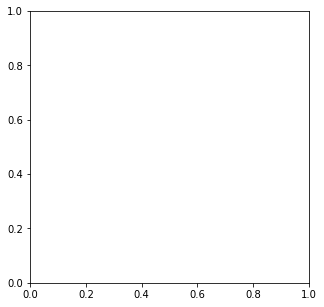

In [276]:
M = 7
N = 7

fig, ax = plt.subplots(1, 1, figsize=[5, 5])
# for i in range(10):
#     env.random_evolution()
# env.render(fig, ax)

Ag = Agent_QN(2, len(ACTIONS.keys()), '0.1', 123)

In [277]:
for i in tqdm(range(1000)):
#     np.random.seed(10)
    env = Environment(M, N, 1, (1,2))
    state = env.state()
    total_reward = 0
    for i in range(10):
        action = Ag.act(env.state(), 0.5)
        env.agents[0].move(action)
        reward, done = env.agent_step(env.agents[0], action)
        total_reward += reward*(0.9**i)
#         print(action, reward)
        
        next_state = env.state()
#         print(next_state.shape)
        Ag.step(state, action, total_reward, next_state, done)
        state = next_state
        if done:
#             print('ok')
            print(len(Ag.memory))
            break










  0%|          | 0/1000 [00:00<?, ?it/s]








  2%|▏         | 20/1000 [00:00<00:05, 191.52it/s]

11
129
152
232











  3%|▎         | 28/1000 [00:00<00:10, 89.60it/s] 

263











  3%|▎         | 34/1000 [00:02<00:59, 16.20it/s]

305
311
313











  4%|▍         | 38/1000 [00:03<01:22, 11.68it/s]








  4%|▍         | 41/1000 [00:04<01:42,  9.40it/s]

366











  4%|▍         | 43/1000 [00:05<01:51,  8.60it/s]








  4%|▍         | 45/1000 [00:05<02:03,  7.76it/s]








  5%|▍         | 47/1000 [00:06<02:13,  7.13it/s]








  5%|▍         | 48/1000 [00:06<02:18,  6.86it/s]








  5%|▍         | 49/1000 [00:07<02:26,  6.51it/s]








  5%|▌         | 50/1000 [00:07<02:31,  6.28it/s]








  5%|▌         | 51/1000 [00:08<02:37,  6.03it/s]








  5%|▌         | 52/1000 [00:08<02:40,  5.92it/s]








  5%|▌         | 53/1000 [00:09<02:46,  5.68it/s]

476











  5%|▌         | 54/1000 [00:09<02:49,  5.57it/s]








  6%|▌         | 55/1000 [00:10<02:56,  5.36it/s]








  6%|▌         | 56/1000 [00:10<02:58,  5.27it/s]








  6%|▌         | 57/1000 [00:11<03:04,  5.12it/s]








  6%|▌         | 58/1000 [00:11<03:06,  5.04it/s]








  6%|▌         | 59/1000 [00:12<03:12,  4.89it/s]








  6%|▌         | 60/1000 [00:12<03:14,  4.84it/s]








  6%|▌         | 61/1000 [00:12<03:19,  4.70it/s]








  6%|▌         | 62/1000 [00:13<03:18,  4.72it/s]

561











  6%|▋         | 63/1000 [00:13<03:22,  4.64it/s]








  6%|▋         | 64/1000 [00:14<03:26,  4.54it/s]








  6%|▋         | 65/1000 [00:14<03:28,  4.49it/s]








  7%|▋         | 66/1000 [00:14<03:31,  4.41it/s]








  7%|▋         | 67/1000 [00:15<03:33,  4.37it/s]








  7%|▋         | 68/1000 [00:15<03:33,  4.37it/s]

615











  7%|▋         | 69/1000 [00:16<03:36,  4.29it/s]








  7%|▋         | 70/1000 [00:16<03:37,  4.27it/s]








  7%|▋         | 71/1000 [00:16<03:41,  4.19it/s]








  7%|▋         | 72/1000 [00:17<03:43,  4.16it/s]








  7%|▋         | 73/1000 [00:17<03:42,  4.17it/s]

656











  7%|▋         | 74/1000 [00:17<03:43,  4.14it/s]








  8%|▊         | 75/1000 [00:18<03:46,  4.08it/s]








  8%|▊         | 76/1000 [00:18<03:47,  4.06it/s]








  8%|▊         | 77/1000 [00:19<03:50,  4.00it/s]








  8%|▊         | 78/1000 [00:19<03:51,  3.99it/s]








  8%|▊         | 79/1000 [00:20<03:54,  3.93it/s]








  8%|▊         | 80/1000 [00:20<03:55,  3.91it/s]








  8%|▊         | 81/1000 [00:21<03:58,  3.85it/s]








  8%|▊         | 82/1000 [00:21<03:57,  3.87it/s]

741











  8%|▊         | 83/1000 [00:21<03:57,  3.86it/s]








  8%|▊         | 84/1000 [00:22<04:00,  3.82it/s]








  8%|▊         | 85/1000 [00:22<04:00,  3.81it/s]








  9%|▊         | 86/1000 [00:22<03:59,  3.82it/s]

772











  9%|▊         | 87/1000 [00:22<03:59,  3.81it/s]








  9%|▉         | 88/1000 [00:23<04:01,  3.77it/s]








  9%|▉         | 89/1000 [00:23<04:00,  3.79it/s]

792
798











  9%|▉         | 90/1000 [00:23<04:02,  3.75it/s]








  9%|▉         | 91/1000 [00:24<04:02,  3.74it/s]

817











  9%|▉         | 92/1000 [00:24<04:03,  3.72it/s]








  9%|▉         | 93/1000 [00:25<04:06,  3.68it/s]








  9%|▉         | 94/1000 [00:25<04:06,  3.67it/s]








 10%|▉         | 95/1000 [00:26<04:08,  3.64it/s]








 10%|▉         | 96/1000 [00:26<04:09,  3.63it/s]








 10%|▉         | 97/1000 [00:26<04:11,  3.59it/s]

877











 10%|▉         | 98/1000 [00:27<04:11,  3.58it/s]








 10%|▉         | 99/1000 [00:27<04:14,  3.55it/s]








 10%|█         | 100/1000 [00:28<04:14,  3.54it/s]








 10%|█         | 101/1000 [00:28<04:16,  3.51it/s]








 10%|█         | 102/1000 [00:29<04:16,  3.50it/s]








 10%|█         | 103/1000 [00:29<04:18,  3.47it/s]








 10%|█         | 104/1000 [00:29<04:18,  3.47it/s]








 10%|█         | 105/1000 [00:30<04:19,  3.44it/s]








 11%|█         | 106/1000 [00:30<04:20,  3.44it/s]








 11%|█         | 107/1000 [00:31<04:21,  3.41it/s]

977











 11%|█         | 108/1000 [00:31<04:21,  3.41it/s]








 11%|█         | 109/1000 [00:32<04:23,  3.39it/s]








 11%|█         | 110/1000 [00:32<04:23,  3.37it/s]








 11%|█         | 111/1000 [00:33<04:26,  3.33it/s]








 11%|█         | 112/1000 [00:33<04:26,  3.33it/s]








 11%|█▏        | 113/1000 [00:34<04:28,  3.31it/s]








 11%|█▏        | 114/1000 [00:34<04:28,  3.29it/s]








 12%|█▏        | 115/1000 [00:35<04:30,  3.27it/s]








 12%|█▏        | 116/1000 [00:35<04:30,  3.27it/s]








 12%|█▏        | 117/1000 [00:36<04:31,  3.25it/s]








 12%|█▏        | 118/1000 [00:36<04:31,  3.25it/s]








 12%|█▏        | 119/1000 [00:36<04:31,  3.25it/s]

1094











 12%|█▏        | 120/1000 [00:37<04:31,  3.24it/s]

1101











 12%|█▏        | 121/1000 [00:37<04:31,  3.24it/s]

1106











 12%|█▏        | 122/1000 [00:37<04:32,  3.22it/s]








 12%|█▏        | 123/1000 [00:38<04:33,  3.21it/s]








 12%|█▏        | 124/1000 [00:38<04:35,  3.18it/s]








 12%|█▎        | 125/1000 [00:39<04:35,  3.18it/s]








 13%|█▎        | 126/1000 [00:39<04:34,  3.18it/s]

1149











 13%|█▎        | 127/1000 [00:40<04:35,  3.17it/s]








 13%|█▎        | 128/1000 [00:40<04:37,  3.14it/s]








 13%|█▎        | 129/1000 [00:41<04:37,  3.14it/s]








 13%|█▎        | 130/1000 [00:41<04:38,  3.12it/s]

1191











 13%|█▎        | 132/1000 [00:42<04:37,  3.13it/s]








 13%|█▎        | 133/1000 [00:42<04:37,  3.13it/s]








 13%|█▎        | 134/1000 [00:43<04:38,  3.11it/s]








 14%|█▎        | 135/1000 [00:43<04:38,  3.10it/s]

1230











 14%|█▎        | 136/1000 [00:44<04:40,  3.08it/s]








 14%|█▎        | 137/1000 [00:44<04:39,  3.09it/s]








 14%|█▍        | 138/1000 [00:44<04:38,  3.10it/s]

1245
1248
1249











 14%|█▍        | 140/1000 [00:44<04:35,  3.12it/s]

1256











 14%|█▍        | 141/1000 [00:45<04:35,  3.12it/s]








 14%|█▍        | 142/1000 [00:45<04:35,  3.11it/s]








 14%|█▍        | 143/1000 [00:45<04:35,  3.11it/s]








 14%|█▍        | 144/1000 [00:46<04:36,  3.10it/s]








 14%|█▍        | 145/1000 [00:46<04:35,  3.10it/s]








 15%|█▍        | 146/1000 [00:47<04:36,  3.09it/s]








 15%|█▍        | 147/1000 [00:47<04:35,  3.09it/s]

1324











 15%|█▍        | 148/1000 [00:47<04:35,  3.09it/s]








 15%|█▍        | 149/1000 [00:48<04:35,  3.09it/s]

1342











 15%|█▌        | 150/1000 [00:48<04:35,  3.08it/s]

1353











 15%|█▌        | 152/1000 [00:49<04:33,  3.10it/s]








 15%|█▌        | 153/1000 [00:49<04:34,  3.09it/s]








 15%|█▌        | 154/1000 [00:49<04:34,  3.09it/s]








 16%|█▌        | 155/1000 [00:50<04:33,  3.09it/s]

1385











 16%|█▌        | 156/1000 [00:50<04:32,  3.09it/s]








 16%|█▌        | 157/1000 [00:51<04:34,  3.07it/s]

1407











 16%|█▌        | 159/1000 [00:51<04:33,  3.07it/s]








 16%|█▌        | 160/1000 [00:52<04:33,  3.07it/s]








 16%|█▌        | 161/1000 [00:52<04:34,  3.06it/s]








 16%|█▌        | 162/1000 [00:52<04:33,  3.06it/s]








 16%|█▋        | 163/1000 [00:53<04:34,  3.05it/s]








 16%|█▋        | 164/1000 [00:53<04:33,  3.05it/s]








 16%|█▋        | 165/1000 [00:54<04:34,  3.05it/s]








 17%|█▋        | 166/1000 [00:54<04:33,  3.04it/s]








 17%|█▋        | 167/1000 [00:55<04:34,  3.04it/s]








 17%|█▋        | 168/1000 [00:55<04:34,  3.03it/s]








 17%|█▋        | 169/1000 [00:55<04:34,  3.03it/s]








 17%|█▋        | 170/1000 [00:56<04:34,  3.02it/s]








 17%|█▋        | 171/1000 [00:56<04:35,  3.01it/s]








 17%|█▋        | 172/1000 [00:57<04:35,  3.01it/s]








 17%|█▋        | 173/1000 [00:57<04:35,  3.00it/s]








 17%|█▋        | 174/1000 [00:57<04:35,  3.00it/s]








 18%|█▊        | 175/1000 [00:58<04:34,  3.01it

1570











 18%|█▊        | 176/1000 [00:58<04:34,  3.00it/s]








 18%|█▊        | 177/1000 [00:58<04:33,  3.00it/s]








 18%|█▊        | 178/1000 [00:59<04:34,  3.00it/s]








 18%|█▊        | 179/1000 [00:59<04:33,  3.00it/s]








 18%|█▊        | 180/1000 [01:00<04:34,  2.99it/s]








 18%|█▊        | 181/1000 [01:00<04:33,  2.99it/s]








 18%|█▊        | 182/1000 [01:00<04:34,  2.98it/s]








 18%|█▊        | 183/1000 [01:01<04:33,  2.98it/s]








 18%|█▊        | 184/1000 [01:01<04:34,  2.98it/s]








 18%|█▊        | 185/1000 [01:02<04:33,  2.98it/s]








 19%|█▊        | 186/1000 [01:02<04:33,  2.97it/s]








 19%|█▊        | 187/1000 [01:02<04:33,  2.97it/s]








 19%|█▉        | 188/1000 [01:03<04:33,  2.97it/s]








 19%|█▉        | 189/1000 [01:03<04:33,  2.97it/s]








 19%|█▉        | 190/1000 [01:04<04:33,  2.96it/s]








 19%|█▉        | 191/1000 [01:04<04:33,  2.96it/s]








 19%|█▉        | 192/1000 [01:04<04:33,  2.95it

1771











 20%|█▉        | 197/1000 [01:06<04:31,  2.95it/s]








 20%|█▉        | 198/1000 [01:07<04:31,  2.95it/s]








 20%|█▉        | 199/1000 [01:07<04:31,  2.95it/s]








 20%|██        | 200/1000 [01:07<04:31,  2.95it/s]








 20%|██        | 201/1000 [01:08<04:31,  2.94it/s]








 20%|██        | 202/1000 [01:08<04:31,  2.94it/s]








 20%|██        | 203/1000 [01:09<04:31,  2.94it/s]








 20%|██        | 204/1000 [01:09<04:31,  2.94it/s]

1850











 20%|██        | 205/1000 [01:09<04:31,  2.93it/s]








 21%|██        | 206/1000 [01:10<04:30,  2.93it/s]








 21%|██        | 207/1000 [01:10<04:31,  2.92it/s]








 21%|██        | 208/1000 [01:11<04:30,  2.93it/s]

1891











 21%|██        | 210/1000 [01:11<04:29,  2.93it/s]








 21%|██        | 211/1000 [01:11<04:28,  2.93it/s]








 21%|██        | 212/1000 [01:12<04:29,  2.93it/s]








 21%|██▏       | 213/1000 [01:12<04:28,  2.93it/s]








 21%|██▏       | 214/1000 [01:12<04:27,  2.94it/s]

1935











 22%|██▏       | 215/1000 [01:13<04:27,  2.93it/s]








 22%|██▏       | 216/1000 [01:13<04:26,  2.94it/s]

1951











 22%|██▏       | 217/1000 [01:14<04:27,  2.93it/s]








 22%|██▏       | 218/1000 [01:14<04:26,  2.93it/s]








 22%|██▏       | 219/1000 [01:14<04:26,  2.93it/s]








 22%|██▏       | 220/1000 [01:15<04:26,  2.93it/s]








 22%|██▏       | 221/1000 [01:15<04:26,  2.92it/s]








 22%|██▏       | 222/1000 [01:15<04:26,  2.92it/s]








 22%|██▏       | 223/1000 [01:16<04:26,  2.92it/s]








 22%|██▏       | 224/1000 [01:16<04:26,  2.92it/s]








 22%|██▎       | 225/1000 [01:16<04:25,  2.92it/s]

2034











 23%|██▎       | 226/1000 [01:17<04:25,  2.92it/s]

2045











 23%|██▎       | 228/1000 [01:17<04:23,  2.93it/s]








 23%|██▎       | 229/1000 [01:18<04:23,  2.93it/s]








 23%|██▎       | 230/1000 [01:18<04:23,  2.93it/s]








 23%|██▎       | 231/1000 [01:19<04:23,  2.92it/s]








 23%|██▎       | 232/1000 [01:19<04:22,  2.92it/s]








 23%|██▎       | 233/1000 [01:19<04:21,  2.93it/s]

2098











 23%|██▎       | 234/1000 [01:20<04:22,  2.92it/s]








 24%|██▎       | 235/1000 [01:20<04:21,  2.92it/s]

2116











 24%|██▎       | 236/1000 [01:20<04:21,  2.92it/s]








 24%|██▎       | 237/1000 [01:21<04:21,  2.92it/s]








 24%|██▍       | 238/1000 [01:21<04:20,  2.92it/s]








 24%|██▍       | 239/1000 [01:22<04:21,  2.91it/s]








 24%|██▍       | 240/1000 [01:22<04:20,  2.91it/s]








 24%|██▍       | 241/1000 [01:22<04:20,  2.91it/s]








 24%|██▍       | 242/1000 [01:23<04:20,  2.91it/s]








 24%|██▍       | 243/1000 [01:23<04:20,  2.91it/s]

2193











 24%|██▍       | 244/1000 [01:23<04:19,  2.91it/s]

2200











 24%|██▍       | 245/1000 [01:24<04:19,  2.91it/s]








 25%|██▍       | 246/1000 [01:24<04:19,  2.91it/s]








 25%|██▍       | 247/1000 [01:24<04:18,  2.91it/s]








 25%|██▍       | 248/1000 [01:25<04:19,  2.90it/s]

2240











 25%|██▍       | 249/1000 [01:25<04:18,  2.90it/s]








 25%|██▌       | 250/1000 [01:26<04:18,  2.90it/s]








 25%|██▌       | 251/1000 [01:26<04:18,  2.90it/s]

2270











 25%|██▌       | 252/1000 [01:26<04:17,  2.90it/s]

2277











 25%|██▌       | 253/1000 [01:27<04:17,  2.90it/s]








 25%|██▌       | 254/1000 [01:27<04:17,  2.89it/s]








 26%|██▌       | 255/1000 [01:28<04:17,  2.89it/s]








 26%|██▌       | 256/1000 [01:28<04:17,  2.89it/s]








 26%|██▌       | 257/1000 [01:29<04:17,  2.89it/s]








 26%|██▌       | 258/1000 [01:29<04:17,  2.88it/s]








 26%|██▌       | 259/1000 [01:29<04:17,  2.88it/s]








 26%|██▌       | 260/1000 [01:30<04:18,  2.86it/s]

2356











 26%|██▌       | 261/1000 [01:31<04:18,  2.85it/s]








 26%|██▌       | 262/1000 [01:32<04:19,  2.84it/s]








 26%|██▋       | 263/1000 [01:32<04:18,  2.85it/s]

2383











 26%|██▋       | 264/1000 [01:32<04:18,  2.84it/s]

2389











 26%|██▋       | 265/1000 [01:33<04:18,  2.84it/s]








 27%|██▋       | 266/1000 [01:33<04:19,  2.83it/s]








 27%|██▋       | 267/1000 [01:34<04:19,  2.82it/s]

2419











 27%|██▋       | 268/1000 [01:35<04:20,  2.81it/s]








 27%|██▋       | 269/1000 [01:35<04:19,  2.82it/s]

2435











 27%|██▋       | 270/1000 [01:36<04:20,  2.80it/s]








 27%|██▋       | 271/1000 [01:36<04:19,  2.81it/s]

2449











 27%|██▋       | 272/1000 [01:36<04:19,  2.81it/s]

2453











 27%|██▋       | 273/1000 [01:37<04:19,  2.80it/s]

2462











 27%|██▋       | 274/1000 [01:38<04:19,  2.79it/s]








 28%|██▊       | 275/1000 [01:38<04:19,  2.79it/s]








 28%|██▊       | 276/1000 [01:39<04:19,  2.79it/s]

2490
2491











 28%|██▊       | 278/1000 [01:39<04:18,  2.79it/s]








 28%|██▊       | 279/1000 [01:40<04:18,  2.79it/s]








 28%|██▊       | 280/1000 [01:40<04:18,  2.78it/s]








 28%|██▊       | 281/1000 [01:41<04:18,  2.78it/s]








 28%|██▊       | 282/1000 [01:41<04:18,  2.78it/s]








 28%|██▊       | 283/1000 [01:41<04:17,  2.78it/s]

2546











 28%|██▊       | 284/1000 [01:42<04:17,  2.78it/s]








 28%|██▊       | 285/1000 [01:42<04:17,  2.77it/s]








 29%|██▊       | 286/1000 [01:43<04:17,  2.77it/s]

2574











 29%|██▊       | 287/1000 [01:43<04:17,  2.77it/s]








 29%|██▉       | 288/1000 [01:43<04:16,  2.78it/s]

2584
2590











 29%|██▉       | 289/1000 [01:43<04:15,  2.78it/s]

2593











 29%|██▉       | 290/1000 [01:44<04:15,  2.78it/s]








 29%|██▉       | 291/1000 [01:44<04:15,  2.78it/s]








 29%|██▉       | 292/1000 [01:45<04:15,  2.77it/s]

2621











 29%|██▉       | 293/1000 [01:45<04:15,  2.77it/s]








 29%|██▉       | 294/1000 [01:46<04:15,  2.77it/s]








 30%|██▉       | 295/1000 [01:46<04:14,  2.77it/s]








 30%|██▉       | 296/1000 [01:47<04:15,  2.76it/s]








 30%|██▉       | 297/1000 [01:47<04:14,  2.76it/s]








 30%|██▉       | 298/1000 [01:47<04:13,  2.77it/s]

2675











 30%|██▉       | 299/1000 [01:48<04:13,  2.76it/s]








 30%|███       | 300/1000 [01:48<04:13,  2.76it/s]








 30%|███       | 301/1000 [01:49<04:13,  2.76it/s]








 30%|███       | 302/1000 [01:49<04:12,  2.76it/s]

2708











 30%|███       | 303/1000 [01:49<04:12,  2.76it/s]








 30%|███       | 304/1000 [01:50<04:12,  2.76it/s]








 31%|███       | 306/1000 [01:50<04:10,  2.77it/s]

2729
2733











 31%|███       | 307/1000 [01:50<04:09,  2.77it/s]








 31%|███       | 308/1000 [01:51<04:09,  2.77it/s]








 31%|███       | 309/1000 [01:51<04:09,  2.77it/s]








 31%|███       | 310/1000 [01:52<04:09,  2.77it/s]








 31%|███       | 311/1000 [01:52<04:08,  2.77it/s]








 31%|███       | 312/1000 [01:52<04:08,  2.76it/s]








 31%|███▏      | 313/1000 [01:53<04:08,  2.77it/s]

2798











 31%|███▏      | 314/1000 [01:53<04:07,  2.77it/s]








 32%|███▏      | 315/1000 [01:53<04:07,  2.77it/s]








 32%|███▏      | 316/1000 [01:54<04:07,  2.76it/s]








 32%|███▏      | 317/1000 [01:54<04:07,  2.76it/s]








 32%|███▏      | 318/1000 [01:55<04:06,  2.76it/s]








 32%|███▏      | 319/1000 [01:55<04:06,  2.76it/s]








 32%|███▏      | 320/1000 [01:55<04:05,  2.77it/s]

2861











 32%|███▏      | 321/1000 [01:55<04:05,  2.77it/s]








 32%|███▏      | 322/1000 [01:56<04:05,  2.76it/s]








 32%|███▏      | 323/1000 [01:56<04:04,  2.77it/s]








 32%|███▏      | 324/1000 [01:57<04:04,  2.76it/s]








 32%|███▎      | 325/1000 [01:57<04:04,  2.76it/s]








 33%|███▎      | 326/1000 [01:58<04:04,  2.76it/s]








 33%|███▎      | 327/1000 [01:58<04:03,  2.76it/s]








 33%|███▎      | 328/1000 [01:58<04:03,  2.76it/s]

2940











 33%|███▎      | 329/1000 [01:59<04:03,  2.76it/s]








 33%|███▎      | 330/1000 [01:59<04:03,  2.76it/s]








 33%|███▎      | 331/1000 [02:00<04:02,  2.76it/s]








 33%|███▎      | 332/1000 [02:00<04:02,  2.75it/s]








 33%|███▎      | 333/1000 [02:00<04:02,  2.76it/s]








 33%|███▎      | 334/1000 [02:01<04:01,  2.75it/s]








 34%|███▎      | 335/1000 [02:01<04:01,  2.75it/s]








 34%|███▎      | 336/1000 [02:02<04:01,  2.75it/s]








 34%|███▎      | 337/1000 [02:02<04:00,  2.75it/s]








 34%|███▍      | 338/1000 [02:03<04:00,  2.75it/s]








 34%|███▍      | 339/1000 [02:03<04:00,  2.75it/s]

3045











 34%|███▍      | 340/1000 [02:03<03:59,  2.75it/s]








 34%|███▍      | 341/1000 [02:03<03:59,  2.75it/s]








 34%|███▍      | 342/1000 [02:04<03:59,  2.75it/s]








 34%|███▍      | 343/1000 [02:04<03:58,  2.76it/s]

3073
3076











 34%|███▍      | 344/1000 [02:04<03:57,  2.76it/s]








 34%|███▍      | 345/1000 [02:05<03:57,  2.76it/s]

3094











 35%|███▍      | 346/1000 [02:05<03:57,  2.75it/s]








 35%|███▍      | 347/1000 [02:05<03:56,  2.76it/s]








 35%|███▍      | 348/1000 [02:06<03:56,  2.75it/s]








 35%|███▍      | 349/1000 [02:06<03:56,  2.75it/s]








 35%|███▌      | 350/1000 [02:07<03:56,  2.75it/s]








 35%|███▌      | 351/1000 [02:07<03:55,  2.75it/s]








 35%|███▌      | 352/1000 [02:08<03:55,  2.75it/s]








 35%|███▌      | 353/1000 [02:08<03:55,  2.75it/s]








 35%|███▌      | 354/1000 [02:08<03:54,  2.75it/s]








 36%|███▌      | 355/1000 [02:08<03:53,  2.76it/s]

3177
3183











 36%|███▌      | 356/1000 [02:09<03:53,  2.76it/s]








 36%|███▌      | 357/1000 [02:09<03:53,  2.76it/s]








 36%|███▌      | 358/1000 [02:09<03:53,  2.75it/s]








 36%|███▌      | 359/1000 [02:10<03:52,  2.75it/s]








 36%|███▌      | 360/1000 [02:10<03:52,  2.75it/s]








 36%|███▌      | 361/1000 [02:11<03:52,  2.75it/s]








 36%|███▌      | 362/1000 [02:11<03:51,  2.75it/s]








 36%|███▋      | 363/1000 [02:11<03:51,  2.75it/s]








 36%|███▋      | 364/1000 [02:12<03:51,  2.75it/s]








 36%|███▋      | 365/1000 [02:12<03:51,  2.75it/s]








 37%|███▋      | 366/1000 [02:12<03:50,  2.75it/s]

3284











 37%|███▋      | 367/1000 [02:13<03:49,  2.75it/s]








 37%|███▋      | 368/1000 [02:13<03:49,  2.75it/s]








 37%|███▋      | 369/1000 [02:14<03:49,  2.75it/s]








 37%|███▋      | 370/1000 [02:14<03:49,  2.75it/s]








 37%|███▋      | 371/1000 [02:14<03:48,  2.75it/s]








 37%|███▋      | 372/1000 [02:15<03:48,  2.75it/s]








 37%|███▋      | 373/1000 [02:15<03:48,  2.75it/s]








 37%|███▋      | 374/1000 [02:16<03:47,  2.75it/s]








 38%|███▊      | 375/1000 [02:16<03:47,  2.75it/s]

3370











 38%|███▊      | 376/1000 [02:16<03:47,  2.75it/s]








 38%|███▊      | 377/1000 [02:17<03:46,  2.75it/s]








 38%|███▊      | 378/1000 [02:17<03:46,  2.75it/s]








 38%|███▊      | 379/1000 [02:18<03:46,  2.75it/s]








 38%|███▊      | 380/1000 [02:18<03:45,  2.74it/s]








 38%|███▊      | 381/1000 [02:18<03:45,  2.74it/s]








 38%|███▊      | 382/1000 [02:19<03:45,  2.74it/s]








 38%|███▊      | 383/1000 [02:19<03:44,  2.74it/s]








 38%|███▊      | 384/1000 [02:20<03:44,  2.74it/s]








 38%|███▊      | 385/1000 [02:20<03:44,  2.74it/s]








 39%|███▊      | 386/1000 [02:20<03:44,  2.74it/s]








 39%|███▊      | 387/1000 [02:21<03:43,  2.74it/s]








 39%|███▉      | 388/1000 [02:21<03:43,  2.74it/s]








 39%|███▉      | 389/1000 [02:22<03:43,  2.74it/s]








 39%|███▉      | 390/1000 [02:22<03:43,  2.73it/s]








 39%|███▉      | 391/1000 [02:22<03:42,  2.74it/s]








 39%|███▉      | 392/1000 [02:23<03:42,  2.73it

3540











 39%|███▉      | 393/1000 [02:23<03:42,  2.73it/s]








 39%|███▉      | 394/1000 [02:24<03:42,  2.73it/s]








 40%|███▉      | 395/1000 [02:24<03:41,  2.73it/s]








 40%|███▉      | 396/1000 [02:25<03:41,  2.73it/s]








 40%|███▉      | 397/1000 [02:25<03:40,  2.73it/s]

3587











 40%|███▉      | 398/1000 [02:25<03:40,  2.73it/s]








 40%|███▉      | 399/1000 [02:26<03:40,  2.73it/s]








 40%|████      | 400/1000 [02:26<03:39,  2.73it/s]








 40%|████      | 401/1000 [02:26<03:39,  2.73it/s]








 40%|████      | 402/1000 [02:27<03:39,  2.73it/s]








 40%|████      | 403/1000 [02:27<03:38,  2.73it/s]








 40%|████      | 404/1000 [02:28<03:38,  2.73it/s]








 40%|████      | 405/1000 [02:28<03:38,  2.73it/s]

3664











 41%|████      | 406/1000 [02:28<03:37,  2.73it/s]








 41%|████      | 407/1000 [02:29<03:37,  2.72it/s]








 41%|████      | 408/1000 [02:29<03:37,  2.73it/s]








 41%|████      | 409/1000 [02:30<03:37,  2.72it/s]








 41%|████      | 410/1000 [02:30<03:36,  2.72it/s]

3712











 41%|████      | 411/1000 [02:30<03:36,  2.72it/s]








 41%|████      | 412/1000 [02:31<03:35,  2.72it/s]








 41%|████▏     | 413/1000 [02:31<03:35,  2.72it/s]








 41%|████▏     | 414/1000 [02:32<03:35,  2.72it/s]








 42%|████▏     | 415/1000 [02:32<03:35,  2.72it/s]








 42%|████▏     | 416/1000 [02:33<03:34,  2.72it/s]

3775











 42%|████▏     | 418/1000 [02:33<03:33,  2.72it/s]








 42%|████▏     | 419/1000 [02:33<03:33,  2.72it/s]

3794











 42%|████▏     | 420/1000 [02:34<03:33,  2.72it/s]








 42%|████▏     | 421/1000 [02:34<03:32,  2.72it/s]








 42%|████▏     | 422/1000 [02:35<03:32,  2.72it/s]








 42%|████▏     | 423/1000 [02:35<03:32,  2.72it/s]








 42%|████▏     | 424/1000 [02:36<03:31,  2.72it/s]








 42%|████▎     | 425/1000 [02:36<03:31,  2.72it/s]

3853











 43%|████▎     | 426/1000 [02:36<03:31,  2.72it/s]








 43%|████▎     | 427/1000 [02:37<03:30,  2.72it/s]

3873











 43%|████▎     | 428/1000 [02:37<03:30,  2.72it/s]








 43%|████▎     | 429/1000 [02:37<03:30,  2.72it/s]








 43%|████▎     | 430/1000 [02:38<03:29,  2.72it/s]








 43%|████▎     | 431/1000 [02:38<03:29,  2.71it/s]








 43%|████▎     | 432/1000 [02:39<03:29,  2.71it/s]








 43%|████▎     | 433/1000 [02:39<03:29,  2.71it/s]








 43%|████▎     | 434/1000 [02:39<03:28,  2.71it/s]








 44%|████▎     | 435/1000 [02:40<03:28,  2.71it/s]








 44%|████▎     | 436/1000 [02:40<03:27,  2.71it/s]








 44%|████▎     | 437/1000 [02:41<03:27,  2.71it/s]








 44%|████▍     | 438/1000 [02:41<03:27,  2.71it/s]








 44%|████▍     | 439/1000 [02:42<03:27,  2.71it/s]








 44%|████▍     | 440/1000 [02:42<03:26,  2.71it/s]








 44%|████▍     | 441/1000 [02:42<03:26,  2.71it/s]

4007











 44%|████▍     | 442/1000 [02:43<03:25,  2.71it/s]








 44%|████▍     | 443/1000 [02:43<03:25,  2.71it/s]








 44%|████▍     | 444/1000 [02:43<03:25,  2.71it/s]








 44%|████▍     | 445/1000 [02:44<03:24,  2.71it/s]








 45%|████▍     | 446/1000 [02:44<03:24,  2.71it/s]








 45%|████▍     | 447/1000 [02:44<03:24,  2.71it/s]








 45%|████▍     | 448/1000 [02:45<03:23,  2.71it/s]








 45%|████▍     | 449/1000 [02:45<03:23,  2.71it/s]








 45%|████▌     | 450/1000 [02:46<03:23,  2.71it/s]








 45%|████▌     | 451/1000 [02:46<03:22,  2.71it/s]








 45%|████▌     | 452/1000 [02:47<03:22,  2.71it/s]








 45%|████▌     | 453/1000 [02:47<03:21,  2.71it/s]

4123











 45%|████▌     | 454/1000 [02:47<03:21,  2.71it/s]








 46%|████▌     | 455/1000 [02:48<03:21,  2.71it/s]








 46%|████▌     | 456/1000 [02:48<03:21,  2.71it/s]








 46%|████▌     | 457/1000 [02:48<03:20,  2.71it/s]








 46%|████▌     | 458/1000 [02:49<03:20,  2.70it/s]

4174











 46%|████▌     | 460/1000 [02:49<03:19,  2.71it/s]








 46%|████▌     | 461/1000 [02:50<03:18,  2.71it/s]

4195











 46%|████▋     | 463/1000 [02:50<03:17,  2.71it/s]








 46%|████▋     | 464/1000 [02:51<03:17,  2.71it/s]








 46%|████▋     | 465/1000 [02:51<03:16,  2.72it/s]

4216
4219











 47%|████▋     | 467/1000 [02:51<03:15,  2.72it/s]

4223











 47%|████▋     | 468/1000 [02:51<03:15,  2.72it/s]








 47%|████▋     | 469/1000 [02:52<03:15,  2.72it/s]








 47%|████▋     | 470/1000 [02:52<03:15,  2.72it/s]








 47%|████▋     | 471/1000 [02:53<03:14,  2.72it/s]








 47%|████▋     | 472/1000 [02:53<03:14,  2.72it/s]








 47%|████▋     | 473/1000 [02:53<03:13,  2.72it/s]

4276
4277











 48%|████▊     | 475/1000 [02:54<03:12,  2.73it/s]








 48%|████▊     | 476/1000 [02:54<03:12,  2.72it/s]








 48%|████▊     | 477/1000 [02:55<03:11,  2.72it/s]








 48%|████▊     | 478/1000 [02:55<03:11,  2.73it/s]

4313











 48%|████▊     | 479/1000 [02:55<03:11,  2.73it/s]

4322











 48%|████▊     | 480/1000 [02:56<03:10,  2.72it/s]








 48%|████▊     | 481/1000 [02:56<03:10,  2.72it/s]








 48%|████▊     | 482/1000 [02:56<03:10,  2.73it/s]

4348











 48%|████▊     | 483/1000 [02:57<03:09,  2.73it/s]








 48%|████▊     | 484/1000 [02:57<03:09,  2.72it/s]








 48%|████▊     | 485/1000 [02:58<03:09,  2.72it/s]








 49%|████▊     | 486/1000 [02:58<03:08,  2.72it/s]








 49%|████▊     | 487/1000 [02:58<03:08,  2.72it/s]








 49%|████▉     | 488/1000 [02:59<03:08,  2.72it/s]








 49%|████▉     | 489/1000 [02:59<03:07,  2.72it/s]








 49%|████▉     | 490/1000 [03:00<03:07,  2.72it/s]








 49%|████▉     | 492/1000 [03:00<03:06,  2.73it/s]

4429
4434











 49%|████▉     | 493/1000 [03:00<03:05,  2.73it/s]








 49%|████▉     | 494/1000 [03:01<03:05,  2.73it/s]








 50%|████▉     | 495/1000 [03:01<03:05,  2.73it/s]








 50%|████▉     | 496/1000 [03:01<03:04,  2.73it/s]








 50%|████▉     | 497/1000 [03:02<03:04,  2.72it/s]








 50%|████▉     | 498/1000 [03:02<03:04,  2.73it/s]

4490











 50%|████▉     | 499/1000 [03:03<03:03,  2.73it/s]








 50%|█████     | 500/1000 [03:03<03:03,  2.73it/s]








 50%|█████     | 501/1000 [03:03<03:03,  2.72it/s]








 50%|█████     | 502/1000 [03:04<03:02,  2.73it/s]








 50%|█████     | 503/1000 [03:04<03:02,  2.72it/s]








 50%|█████     | 504/1000 [03:04<03:02,  2.72it/s]








 50%|█████     | 505/1000 [03:05<03:01,  2.72it/s]








 51%|█████     | 506/1000 [03:05<03:01,  2.72it/s]








 51%|█████     | 507/1000 [03:06<03:01,  2.72it/s]








 51%|█████     | 508/1000 [03:06<03:00,  2.72it/s]








 51%|█████     | 509/1000 [03:07<03:00,  2.72it/s]








 51%|█████     | 510/1000 [03:07<03:00,  2.72it/s]








 51%|█████     | 511/1000 [03:07<02:59,  2.72it/s]








 51%|█████     | 512/1000 [03:08<02:59,  2.72it/s]








 51%|█████▏    | 513/1000 [03:08<02:59,  2.72it/s]








 52%|█████▏    | 515/1000 [03:08<02:57,  2.73it/s]

4641
4646











 52%|█████▏    | 516/1000 [03:09<02:57,  2.72it/s]








 52%|█████▏    | 517/1000 [03:09<02:57,  2.73it/s]

4662











 52%|█████▏    | 518/1000 [03:10<02:56,  2.73it/s]








 52%|█████▏    | 519/1000 [03:10<02:56,  2.73it/s]








 52%|█████▏    | 520/1000 [03:10<02:56,  2.72it/s]








 52%|█████▏    | 521/1000 [03:11<02:55,  2.72it/s]








 52%|█████▏    | 522/1000 [03:11<02:55,  2.72it/s]








 52%|█████▏    | 523/1000 [03:12<02:55,  2.72it/s]

4721











 52%|█████▏    | 524/1000 [03:12<02:54,  2.72it/s]








 52%|█████▎    | 525/1000 [03:12<02:54,  2.72it/s]








 53%|█████▎    | 526/1000 [03:13<02:54,  2.72it/s]








 53%|█████▎    | 527/1000 [03:13<02:53,  2.72it/s]








 53%|█████▎    | 528/1000 [03:13<02:53,  2.72it/s]








 53%|█████▎    | 529/1000 [03:14<02:53,  2.72it/s]








 53%|█████▎    | 530/1000 [03:14<02:52,  2.72it/s]








 53%|█████▎    | 531/1000 [03:15<02:52,  2.72it/s]








 53%|█████▎    | 532/1000 [03:15<02:52,  2.72it/s]








 53%|█████▎    | 533/1000 [03:16<02:51,  2.72it/s]








 53%|█████▎    | 534/1000 [03:16<02:51,  2.72it/s]

4824
4825











 54%|█████▎    | 536/1000 [03:16<02:50,  2.73it/s]

4832
4833











 54%|█████▍    | 538/1000 [03:17<02:49,  2.73it/s]








 54%|█████▍    | 539/1000 [03:17<02:48,  2.73it/s]

4854











 54%|█████▍    | 541/1000 [03:17<02:47,  2.73it/s]








 54%|█████▍    | 542/1000 [03:18<02:47,  2.74it/s]

4863
4865











 54%|█████▍    | 543/1000 [03:18<02:46,  2.74it/s]

4868











 54%|█████▍    | 544/1000 [03:18<02:46,  2.74it/s]








 55%|█████▍    | 545/1000 [03:19<02:46,  2.74it/s]








 55%|█████▍    | 546/1000 [03:19<02:45,  2.74it/s]








 55%|█████▍    | 547/1000 [03:19<02:45,  2.74it/s]








 55%|█████▍    | 548/1000 [03:20<02:45,  2.74it/s]








 55%|█████▍    | 549/1000 [03:20<02:44,  2.74it/s]

4926











 55%|█████▌    | 550/1000 [03:20<02:44,  2.74it/s]








 55%|█████▌    | 551/1000 [03:21<02:44,  2.74it/s]








 55%|█████▌    | 552/1000 [03:21<02:43,  2.74it/s]








 55%|█████▌    | 553/1000 [03:21<02:42,  2.74it/s]

4948
4955











 55%|█████▌    | 554/1000 [03:22<02:42,  2.74it/s]








 56%|█████▌    | 555/1000 [03:22<02:42,  2.74it/s]








 56%|█████▌    | 556/1000 [03:22<02:42,  2.74it/s]








 56%|█████▌    | 557/1000 [03:23<02:41,  2.74it/s]








 56%|█████▌    | 558/1000 [03:23<02:41,  2.74it/s]








 56%|█████▌    | 559/1000 [03:24<02:40,  2.74it/s]








 56%|█████▌    | 560/1000 [03:24<02:40,  2.74it/s]








 56%|█████▌    | 561/1000 [03:24<02:40,  2.74it/s]

5032











 56%|█████▌    | 562/1000 [03:25<02:39,  2.74it/s]








 56%|█████▋    | 563/1000 [03:25<02:39,  2.74it/s]








 56%|█████▋    | 564/1000 [03:26<02:39,  2.74it/s]








 56%|█████▋    | 565/1000 [03:26<02:39,  2.74it/s]








 57%|█████▋    | 566/1000 [03:26<02:38,  2.74it/s]








 57%|█████▋    | 567/1000 [03:27<02:38,  2.73it/s]








 57%|█████▋    | 568/1000 [03:27<02:37,  2.74it/s]








 57%|█████▋    | 569/1000 [03:27<02:37,  2.74it/s]

5105











 57%|█████▋    | 570/1000 [03:28<02:37,  2.74it/s]








 57%|█████▋    | 571/1000 [03:28<02:36,  2.74it/s]

5123











 57%|█████▋    | 572/1000 [03:28<02:36,  2.74it/s]








 57%|█████▋    | 573/1000 [03:29<02:35,  2.74it/s]

5137











 57%|█████▋    | 574/1000 [03:29<02:35,  2.74it/s]








 57%|█████▊    | 575/1000 [03:29<02:35,  2.74it/s]








 58%|█████▊    | 576/1000 [03:30<02:34,  2.74it/s]

5167











 58%|█████▊    | 577/1000 [03:30<02:34,  2.74it/s]








 58%|█████▊    | 578/1000 [03:31<02:34,  2.74it/s]

5185











 58%|█████▊    | 579/1000 [03:31<02:33,  2.74it/s]








 58%|█████▊    | 580/1000 [03:31<02:33,  2.74it/s]

5207











 58%|█████▊    | 582/1000 [03:32<02:32,  2.74it/s]








 58%|█████▊    | 583/1000 [03:32<02:32,  2.74it/s]








 58%|█████▊    | 584/1000 [03:32<02:31,  2.74it/s]

5229











 58%|█████▊    | 585/1000 [03:33<02:31,  2.74it/s]








 59%|█████▊    | 586/1000 [03:33<02:30,  2.74it/s]








 59%|█████▊    | 587/1000 [03:34<02:30,  2.74it/s]








 59%|█████▉    | 588/1000 [03:34<02:30,  2.74it/s]








 59%|█████▉    | 589/1000 [03:34<02:29,  2.74it/s]

5275











 59%|█████▉    | 590/1000 [03:35<02:29,  2.74it/s]








 59%|█████▉    | 591/1000 [03:35<02:29,  2.74it/s]








 59%|█████▉    | 592/1000 [03:35<02:28,  2.74it/s]








 59%|█████▉    | 593/1000 [03:36<02:28,  2.74it/s]








 59%|█████▉    | 594/1000 [03:36<02:28,  2.74it/s]








 60%|█████▉    | 595/1000 [03:37<02:27,  2.74it/s]








 60%|█████▉    | 596/1000 [03:37<02:27,  2.74it/s]








 60%|█████▉    | 597/1000 [03:37<02:27,  2.74it/s]

5350











 60%|█████▉    | 598/1000 [03:38<02:26,  2.74it/s]








 60%|█████▉    | 599/1000 [03:38<02:26,  2.74it/s]








 60%|██████    | 600/1000 [03:39<02:26,  2.74it/s]

5381











 60%|██████    | 602/1000 [03:39<02:25,  2.74it/s]








 60%|██████    | 603/1000 [03:39<02:24,  2.74it/s]








 60%|██████    | 604/1000 [03:40<02:24,  2.74it/s]

5406











 60%|██████    | 605/1000 [03:40<02:24,  2.74it/s]








 61%|██████    | 606/1000 [03:40<02:23,  2.74it/s]








 61%|██████    | 607/1000 [03:41<02:23,  2.74it/s]








 61%|██████    | 608/1000 [03:41<02:22,  2.74it/s]

5441
5443











 61%|██████    | 610/1000 [03:42<02:21,  2.75it/s]








 61%|██████    | 611/1000 [03:42<02:21,  2.75it/s]








 61%|██████    | 612/1000 [03:42<02:21,  2.75it/s]

5470











 61%|██████▏   | 613/1000 [03:43<02:20,  2.75it/s]








 61%|██████▏   | 614/1000 [03:43<02:20,  2.75it/s]








 62%|██████▏   | 615/1000 [03:43<02:20,  2.75it/s]








 62%|██████▏   | 616/1000 [03:44<02:19,  2.75it/s]

5510











 62%|██████▏   | 617/1000 [03:44<02:19,  2.74it/s]








 62%|██████▏   | 618/1000 [03:45<02:19,  2.75it/s]








 62%|██████▏   | 619/1000 [03:45<02:18,  2.74it/s]








 62%|██████▏   | 620/1000 [03:45<02:18,  2.74it/s]








 62%|██████▏   | 621/1000 [03:46<02:18,  2.74it/s]








 62%|██████▏   | 622/1000 [03:46<02:17,  2.75it/s]

5567











 62%|██████▏   | 623/1000 [03:47<02:17,  2.74it/s]








 62%|██████▏   | 624/1000 [03:47<02:17,  2.74it/s]








 62%|██████▎   | 625/1000 [03:47<02:16,  2.74it/s]








 63%|██████▎   | 626/1000 [03:48<02:16,  2.74it/s]








 63%|██████▎   | 627/1000 [03:48<02:15,  2.74it/s]

5614











 63%|██████▎   | 628/1000 [03:48<02:15,  2.74it/s]








 63%|██████▎   | 629/1000 [03:49<02:15,  2.74it/s]








 63%|██████▎   | 630/1000 [03:49<02:14,  2.74it/s]








 63%|██████▎   | 631/1000 [03:50<02:14,  2.74it/s]








 63%|██████▎   | 632/1000 [03:50<02:14,  2.74it/s]

5658











 63%|██████▎   | 633/1000 [03:50<02:13,  2.74it/s]








 63%|██████▎   | 634/1000 [03:51<02:13,  2.74it/s]








 64%|██████▎   | 635/1000 [03:51<02:13,  2.74it/s]








 64%|██████▎   | 636/1000 [03:52<02:12,  2.74it/s]








 64%|██████▎   | 637/1000 [03:52<02:12,  2.74it/s]








 64%|██████▍   | 638/1000 [03:52<02:12,  2.74it/s]








 64%|██████▍   | 639/1000 [03:53<02:11,  2.74it/s]

5722











 64%|██████▍   | 640/1000 [03:53<02:11,  2.74it/s]








 64%|██████▍   | 641/1000 [03:53<02:10,  2.74it/s]








 64%|██████▍   | 642/1000 [03:54<02:10,  2.74it/s]

5749











 64%|██████▍   | 643/1000 [03:54<02:10,  2.74it/s]








 64%|██████▍   | 644/1000 [03:55<02:09,  2.74it/s]








 64%|██████▍   | 645/1000 [03:55<02:09,  2.74it/s]








 65%|██████▍   | 646/1000 [03:55<02:09,  2.74it/s]








 65%|██████▍   | 647/1000 [03:56<02:08,  2.74it/s]








 65%|██████▍   | 648/1000 [03:56<02:08,  2.74it/s]








 65%|██████▍   | 649/1000 [03:56<02:08,  2.74it/s]








 65%|██████▌   | 650/1000 [03:57<02:07,  2.74it/s]








 65%|██████▌   | 651/1000 [03:57<02:07,  2.74it/s]








 65%|██████▌   | 652/1000 [03:58<02:07,  2.74it/s]








 65%|██████▌   | 653/1000 [03:58<02:06,  2.74it/s]








 65%|██████▌   | 654/1000 [03:59<02:06,  2.74it/s]

5867











 66%|██████▌   | 655/1000 [03:59<02:06,  2.73it/s]








 66%|██████▌   | 656/1000 [03:59<02:05,  2.74it/s]








 66%|██████▌   | 657/1000 [04:00<02:05,  2.74it/s]

5888











 66%|██████▌   | 658/1000 [04:00<02:04,  2.74it/s]








 66%|██████▌   | 660/1000 [04:00<02:03,  2.74it/s]

5899
5902











 66%|██████▌   | 661/1000 [04:00<02:03,  2.74it/s]








 66%|██████▌   | 662/1000 [04:01<02:03,  2.74it/s]








 66%|██████▋   | 663/1000 [04:01<02:02,  2.74it/s]








 66%|██████▋   | 664/1000 [04:02<02:02,  2.74it/s]

5942











 66%|██████▋   | 665/1000 [04:02<02:02,  2.74it/s]








 67%|██████▋   | 666/1000 [04:03<02:01,  2.74it/s]








 67%|██████▋   | 667/1000 [04:03<02:01,  2.74it/s]








 67%|██████▋   | 668/1000 [04:03<02:01,  2.74it/s]








 67%|██████▋   | 669/1000 [04:04<02:00,  2.74it/s]

5980
5984











 67%|██████▋   | 670/1000 [04:04<02:00,  2.74it/s]








 67%|██████▋   | 671/1000 [04:04<01:59,  2.74it/s]

6001











 67%|██████▋   | 672/1000 [04:05<01:59,  2.74it/s]








 67%|██████▋   | 673/1000 [04:05<01:59,  2.74it/s]

6018











 67%|██████▋   | 674/1000 [04:05<01:58,  2.74it/s]








 68%|██████▊   | 675/1000 [04:06<01:58,  2.74it/s]








 68%|██████▊   | 676/1000 [04:06<01:58,  2.74it/s]








 68%|██████▊   | 677/1000 [04:06<01:57,  2.74it/s]

6053











 68%|██████▊   | 678/1000 [04:07<01:57,  2.74it/s]








 68%|██████▊   | 679/1000 [04:07<01:57,  2.74it/s]








 68%|██████▊   | 680/1000 [04:07<01:56,  2.74it/s]

6078











 68%|██████▊   | 681/1000 [04:08<01:56,  2.74it/s]

6088











 68%|██████▊   | 682/1000 [04:08<01:55,  2.74it/s]








 68%|██████▊   | 683/1000 [04:09<01:55,  2.74it/s]








 68%|██████▊   | 684/1000 [04:09<01:55,  2.74it/s]








 68%|██████▊   | 685/1000 [04:09<01:54,  2.74it/s]








 69%|██████▊   | 686/1000 [04:10<01:54,  2.74it/s]

6137











 69%|██████▊   | 687/1000 [04:10<01:54,  2.74it/s]

6143











 69%|██████▉   | 688/1000 [04:11<01:53,  2.74it/s]

6153
6155











 69%|██████▉   | 690/1000 [04:11<01:53,  2.74it/s]








 69%|██████▉   | 691/1000 [04:11<01:52,  2.74it/s]








 69%|██████▉   | 692/1000 [04:12<01:52,  2.74it/s]








 69%|██████▉   | 693/1000 [04:12<01:52,  2.74it/s]








 69%|██████▉   | 694/1000 [04:13<01:51,  2.74it/s]

6205











 70%|██████▉   | 695/1000 [04:13<01:51,  2.74it/s]








 70%|██████▉   | 696/1000 [04:14<01:51,  2.74it/s]








 70%|██████▉   | 697/1000 [04:14<01:50,  2.74it/s]








 70%|██████▉   | 698/1000 [04:15<01:50,  2.73it/s]








 70%|██████▉   | 699/1000 [04:15<01:50,  2.73it/s]








 70%|███████   | 700/1000 [04:15<01:49,  2.74it/s]

6256











 70%|███████   | 701/1000 [04:16<01:49,  2.74it/s]

6264











 70%|███████   | 702/1000 [04:16<01:48,  2.74it/s]








 70%|███████   | 703/1000 [04:16<01:48,  2.74it/s]








 70%|███████   | 704/1000 [04:17<01:48,  2.74it/s]








 70%|███████   | 705/1000 [04:17<01:47,  2.74it/s]

6297











 71%|███████   | 706/1000 [04:17<01:47,  2.74it/s]








 71%|███████   | 707/1000 [04:18<01:47,  2.74it/s]








 71%|███████   | 708/1000 [04:18<01:46,  2.74it/s]








 71%|███████   | 709/1000 [04:18<01:46,  2.74it/s]

6328











 71%|███████   | 710/1000 [04:19<01:45,  2.74it/s]








 71%|███████   | 711/1000 [04:19<01:45,  2.74it/s]








 71%|███████   | 712/1000 [04:20<01:45,  2.74it/s]








 71%|███████▏  | 713/1000 [04:20<01:44,  2.73it/s]








 71%|███████▏  | 714/1000 [04:21<01:44,  2.74it/s]








 72%|███████▏  | 715/1000 [04:21<01:44,  2.73it/s]








 72%|███████▏  | 716/1000 [04:22<01:43,  2.73it/s]








 72%|███████▏  | 717/1000 [04:22<01:43,  2.73it/s]

6401











 72%|███████▏  | 718/1000 [04:22<01:43,  2.73it/s]








 72%|███████▏  | 719/1000 [04:23<01:42,  2.73it/s]








 72%|███████▏  | 720/1000 [04:23<01:42,  2.73it/s]








 72%|███████▏  | 721/1000 [04:24<01:42,  2.73it/s]








 72%|███████▏  | 722/1000 [04:24<01:41,  2.73it/s]








 72%|███████▏  | 723/1000 [04:25<01:41,  2.73it/s]








 72%|███████▏  | 724/1000 [04:25<01:41,  2.73it/s]








 72%|███████▎  | 725/1000 [04:26<01:40,  2.72it/s]








 73%|███████▎  | 726/1000 [04:26<01:40,  2.72it/s]








 73%|███████▎  | 727/1000 [04:26<01:40,  2.73it/s]

6494











 73%|███████▎  | 728/1000 [04:27<01:39,  2.72it/s]








 73%|███████▎  | 729/1000 [04:27<01:39,  2.72it/s]








 73%|███████▎  | 730/1000 [04:28<01:39,  2.72it/s]








 73%|███████▎  | 731/1000 [04:28<01:38,  2.72it/s]

6524
6528











 73%|███████▎  | 732/1000 [04:28<01:38,  2.72it/s]








 73%|███████▎  | 733/1000 [04:29<01:38,  2.72it/s]








 73%|███████▎  | 734/1000 [04:29<01:37,  2.72it/s]








 74%|███████▎  | 735/1000 [04:29<01:37,  2.73it/s]

6560











 74%|███████▎  | 736/1000 [04:30<01:36,  2.73it/s]








 74%|███████▎  | 737/1000 [04:30<01:36,  2.72it/s]








 74%|███████▍  | 738/1000 [04:30<01:36,  2.72it/s]








 74%|███████▍  | 739/1000 [04:31<01:35,  2.73it/s]

6588
6595











 74%|███████▍  | 740/1000 [04:31<01:35,  2.73it/s]








 74%|███████▍  | 741/1000 [04:31<01:35,  2.73it/s]








 74%|███████▍  | 742/1000 [04:32<01:34,  2.72it/s]








 74%|███████▍  | 743/1000 [04:32<01:34,  2.73it/s]

6624
6631











 74%|███████▍  | 744/1000 [04:33<01:33,  2.72it/s]








 74%|███████▍  | 745/1000 [04:33<01:33,  2.72it/s]








 75%|███████▍  | 746/1000 [04:34<01:33,  2.72it/s]








 75%|███████▍  | 747/1000 [04:34<01:32,  2.72it/s]








 75%|███████▍  | 748/1000 [04:34<01:32,  2.72it/s]

6679











 75%|███████▍  | 749/1000 [04:35<01:32,  2.72it/s]








 75%|███████▌  | 750/1000 [04:35<01:31,  2.72it/s]








 75%|███████▌  | 751/1000 [04:36<01:31,  2.72it/s]








 75%|███████▌  | 752/1000 [04:36<01:31,  2.72it/s]








 75%|███████▌  | 753/1000 [04:37<01:30,  2.72it/s]








 75%|███████▌  | 754/1000 [04:37<01:30,  2.72it/s]

6738











 76%|███████▌  | 755/1000 [04:38<01:30,  2.72it/s]








 76%|███████▌  | 756/1000 [04:38<01:29,  2.72it/s]








 76%|███████▌  | 757/1000 [04:38<01:29,  2.71it/s]








 76%|███████▌  | 758/1000 [04:39<01:29,  2.72it/s]








 76%|███████▌  | 759/1000 [04:39<01:28,  2.72it/s]

6783











 76%|███████▌  | 760/1000 [04:39<01:28,  2.72it/s]








 76%|███████▌  | 761/1000 [04:40<01:27,  2.72it/s]








 76%|███████▌  | 762/1000 [04:40<01:27,  2.72it/s]








 76%|███████▋  | 763/1000 [04:40<01:27,  2.72it/s]








 76%|███████▋  | 764/1000 [04:41<01:26,  2.71it/s]








 76%|███████▋  | 765/1000 [04:41<01:26,  2.72it/s]

6837











 77%|███████▋  | 766/1000 [04:41<01:26,  2.72it/s]








 77%|███████▋  | 767/1000 [04:42<01:25,  2.72it/s]








 77%|███████▋  | 768/1000 [04:42<01:25,  2.72it/s]








 77%|███████▋  | 769/1000 [04:43<01:25,  2.71it/s]

6879











 77%|███████▋  | 771/1000 [04:43<01:24,  2.72it/s]








 77%|███████▋  | 772/1000 [04:44<01:23,  2.72it/s]








 77%|███████▋  | 773/1000 [04:44<01:23,  2.72it/s]








 77%|███████▋  | 774/1000 [04:44<01:23,  2.72it/s]








 78%|███████▊  | 775/1000 [04:45<01:22,  2.72it/s]

6924











 78%|███████▊  | 776/1000 [04:45<01:22,  2.72it/s]








 78%|███████▊  | 777/1000 [04:46<01:22,  2.72it/s]








 78%|███████▊  | 778/1000 [04:46<01:21,  2.71it/s]

6955











 78%|███████▊  | 780/1000 [04:47<01:21,  2.72it/s]








 78%|███████▊  | 781/1000 [04:47<01:20,  2.72it/s]

6974











 78%|███████▊  | 782/1000 [04:48<01:20,  2.71it/s]








 78%|███████▊  | 783/1000 [04:48<01:19,  2.71it/s]








 78%|███████▊  | 784/1000 [04:48<01:19,  2.72it/s]

6997
6999











 79%|███████▊  | 786/1000 [04:49<01:18,  2.72it/s]








 79%|███████▊  | 787/1000 [04:49<01:18,  2.72it/s]








 79%|███████▉  | 788/1000 [04:49<01:18,  2.72it/s]

7024











 79%|███████▉  | 789/1000 [04:50<01:17,  2.72it/s]

7033











 79%|███████▉  | 790/1000 [04:50<01:17,  2.72it/s]








 79%|███████▉  | 791/1000 [04:51<01:17,  2.71it/s]








 79%|███████▉  | 792/1000 [04:52<01:16,  2.71it/s]








 79%|███████▉  | 793/1000 [04:52<01:16,  2.71it/s]








 79%|███████▉  | 794/1000 [04:52<01:15,  2.71it/s]








 80%|███████▉  | 795/1000 [04:53<01:15,  2.71it/s]








 80%|███████▉  | 796/1000 [04:53<01:15,  2.71it/s]








 80%|███████▉  | 797/1000 [04:54<01:14,  2.71it/s]








 80%|███████▉  | 798/1000 [04:54<01:14,  2.71it/s]








 80%|███████▉  | 799/1000 [04:54<01:14,  2.71it/s]

7124











 80%|████████  | 800/1000 [04:54<01:13,  2.71it/s]








 80%|████████  | 801/1000 [04:55<01:13,  2.71it/s]








 80%|████████  | 802/1000 [04:55<01:13,  2.71it/s]

7152











 80%|████████  | 803/1000 [04:56<01:12,  2.71it/s]








 80%|████████  | 804/1000 [04:56<01:12,  2.71it/s]








 80%|████████  | 805/1000 [04:57<01:11,  2.71it/s]

7181











 81%|████████  | 806/1000 [04:57<01:11,  2.71it/s]








 81%|████████  | 807/1000 [04:57<01:11,  2.71it/s]

7196











 81%|████████  | 808/1000 [04:58<01:10,  2.71it/s]








 81%|████████  | 809/1000 [04:58<01:10,  2.71it/s]

7211











 81%|████████  | 810/1000 [04:58<01:10,  2.71it/s]








 81%|████████  | 811/1000 [04:59<01:09,  2.71it/s]








 81%|████████  | 812/1000 [04:59<01:09,  2.71it/s]








 81%|████████▏ | 813/1000 [04:59<01:08,  2.71it/s]

7250











 81%|████████▏ | 814/1000 [05:00<01:08,  2.71it/s]








 82%|████████▏ | 815/1000 [05:00<01:08,  2.71it/s]








 82%|████████▏ | 816/1000 [05:01<01:07,  2.71it/s]








 82%|████████▏ | 817/1000 [05:01<01:07,  2.71it/s]








 82%|████████▏ | 818/1000 [05:02<01:07,  2.71it/s]








 82%|████████▏ | 819/1000 [05:02<01:06,  2.71it/s]








 82%|████████▏ | 820/1000 [05:03<01:06,  2.70it/s]

7323











 82%|████████▏ | 822/1000 [05:04<01:05,  2.70it/s]








 82%|████████▏ | 823/1000 [05:04<01:05,  2.70it/s]

7339











 82%|████████▏ | 824/1000 [05:05<01:05,  2.70it/s]








 82%|████████▎ | 825/1000 [05:05<01:04,  2.70it/s]








 83%|████████▎ | 826/1000 [05:05<01:04,  2.70it/s]

7362











 83%|████████▎ | 827/1000 [05:06<01:04,  2.70it/s]








 83%|████████▎ | 828/1000 [05:06<01:03,  2.70it/s]








 83%|████████▎ | 829/1000 [05:07<01:03,  2.70it/s]








 83%|████████▎ | 830/1000 [05:07<01:02,  2.70it/s]








 83%|████████▎ | 831/1000 [05:07<01:02,  2.70it/s]








 83%|████████▎ | 832/1000 [05:08<01:02,  2.70it/s]








 83%|████████▎ | 833/1000 [05:08<01:01,  2.70it/s]

7428











 83%|████████▎ | 834/1000 [05:09<01:01,  2.70it/s]








 84%|████████▎ | 835/1000 [05:10<01:01,  2.69it/s]








 84%|████████▎ | 836/1000 [05:10<01:00,  2.69it/s]

7459











 84%|████████▍ | 838/1000 [05:11<01:00,  2.69it/s]

7465











 84%|████████▍ | 839/1000 [05:12<00:59,  2.69it/s]








 84%|████████▍ | 840/1000 [05:12<00:59,  2.69it/s]

7481











 84%|████████▍ | 841/1000 [05:13<00:59,  2.68it/s]








 84%|████████▍ | 842/1000 [05:14<00:58,  2.68it/s]








 84%|████████▍ | 843/1000 [05:14<00:58,  2.68it/s]








 84%|████████▍ | 844/1000 [05:15<00:58,  2.67it/s]








 84%|████████▍ | 845/1000 [05:15<00:57,  2.67it/s]

7525











 85%|████████▍ | 846/1000 [05:16<00:57,  2.67it/s]








 85%|████████▍ | 847/1000 [05:16<00:57,  2.67it/s]








 85%|████████▍ | 848/1000 [05:17<00:56,  2.67it/s]








 85%|████████▍ | 849/1000 [05:17<00:56,  2.67it/s]

7565











 85%|████████▌ | 850/1000 [05:18<00:56,  2.67it/s]








 85%|████████▌ | 851/1000 [05:18<00:55,  2.67it/s]

7586











 85%|████████▌ | 853/1000 [05:19<00:55,  2.67it/s]








 85%|████████▌ | 854/1000 [05:19<00:54,  2.67it/s]








 86%|████████▌ | 855/1000 [05:20<00:54,  2.67it/s]








 86%|████████▌ | 856/1000 [05:20<00:53,  2.67it/s]








 86%|████████▌ | 857/1000 [05:21<00:53,  2.67it/s]








 86%|████████▌ | 858/1000 [05:21<00:53,  2.67it/s]








 86%|████████▌ | 859/1000 [05:21<00:52,  2.67it/s]

7654











 86%|████████▌ | 860/1000 [05:22<00:52,  2.67it/s]








 86%|████████▌ | 861/1000 [05:22<00:52,  2.67it/s]








 86%|████████▌ | 862/1000 [05:23<00:51,  2.67it/s]








 86%|████████▋ | 863/1000 [05:23<00:51,  2.67it/s]








 86%|████████▋ | 864/1000 [05:24<00:51,  2.67it/s]








 86%|████████▋ | 865/1000 [05:24<00:50,  2.67it/s]








 87%|████████▋ | 866/1000 [05:24<00:50,  2.66it/s]








 87%|████████▋ | 867/1000 [05:25<00:49,  2.66it/s]

7732
7734











 87%|████████▋ | 869/1000 [05:25<00:49,  2.67it/s]








 87%|████████▋ | 870/1000 [05:26<00:48,  2.67it/s]








 87%|████████▋ | 871/1000 [05:26<00:48,  2.66it/s]








 87%|████████▋ | 872/1000 [05:27<00:48,  2.67it/s]

7768
7769











 87%|████████▋ | 874/1000 [05:27<00:47,  2.67it/s]








 88%|████████▊ | 875/1000 [05:27<00:46,  2.67it/s]

7781











 88%|████████▊ | 876/1000 [05:27<00:46,  2.67it/s]








 88%|████████▊ | 877/1000 [05:28<00:46,  2.67it/s]

7800











 88%|████████▊ | 878/1000 [05:28<00:45,  2.67it/s]








 88%|████████▊ | 879/1000 [05:29<00:45,  2.67it/s]








 88%|████████▊ | 880/1000 [05:29<00:44,  2.67it/s]








 88%|████████▊ | 881/1000 [05:30<00:44,  2.67it/s]








 88%|████████▊ | 882/1000 [05:30<00:44,  2.67it/s]

7846











 88%|████████▊ | 883/1000 [05:30<00:43,  2.67it/s]








 88%|████████▊ | 884/1000 [05:31<00:43,  2.67it/s]








 88%|████████▊ | 885/1000 [05:31<00:43,  2.67it/s]








 89%|████████▊ | 886/1000 [05:32<00:42,  2.67it/s]








 89%|████████▊ | 887/1000 [05:32<00:42,  2.67it/s]








 89%|████████▉ | 888/1000 [05:33<00:42,  2.67it/s]








 89%|████████▉ | 889/1000 [05:33<00:41,  2.67it/s]








 89%|████████▉ | 890/1000 [05:33<00:41,  2.67it/s]








 89%|████████▉ | 891/1000 [05:34<00:40,  2.66it/s]








 89%|████████▉ | 892/1000 [05:34<00:40,  2.66it/s]








 89%|████████▉ | 893/1000 [05:34<00:40,  2.67it/s]

7948











 89%|████████▉ | 894/1000 [05:35<00:39,  2.67it/s]








 90%|████████▉ | 895/1000 [05:35<00:39,  2.67it/s]

7964











 90%|████████▉ | 896/1000 [05:36<00:39,  2.67it/s]








 90%|████████▉ | 897/1000 [05:36<00:38,  2.67it/s]

7978











 90%|████████▉ | 898/1000 [05:36<00:38,  2.67it/s]








 90%|████████▉ | 899/1000 [05:37<00:37,  2.67it/s]








 90%|█████████ | 900/1000 [05:37<00:37,  2.67it/s]








 90%|█████████ | 901/1000 [05:37<00:37,  2.67it/s]








 90%|█████████ | 902/1000 [05:38<00:36,  2.67it/s]








 90%|█████████ | 903/1000 [05:38<00:36,  2.67it/s]








 90%|█████████ | 904/1000 [05:39<00:36,  2.66it/s]








 90%|█████████ | 905/1000 [05:39<00:35,  2.67it/s]








 91%|█████████ | 906/1000 [05:39<00:35,  2.67it/s]

8064











 91%|█████████ | 907/1000 [05:40<00:34,  2.67it/s]








 91%|█████████ | 908/1000 [05:40<00:34,  2.66it/s]








 91%|█████████ | 909/1000 [05:41<00:34,  2.66it/s]

8093











 91%|█████████ | 910/1000 [05:41<00:33,  2.66it/s]








 91%|█████████ | 911/1000 [05:41<00:33,  2.66it/s]








 91%|█████████ | 912/1000 [05:42<00:33,  2.66it/s]








 91%|█████████▏| 913/1000 [05:42<00:32,  2.67it/s]

8124











 91%|█████████▏| 914/1000 [05:42<00:32,  2.67it/s]








 92%|█████████▏| 915/1000 [05:43<00:31,  2.66it/s]








 92%|█████████▏| 916/1000 [05:43<00:31,  2.67it/s]








 92%|█████████▏| 917/1000 [05:44<00:31,  2.67it/s]

8161











 92%|█████████▏| 918/1000 [05:44<00:30,  2.67it/s]








 92%|█████████▏| 919/1000 [05:44<00:30,  2.67it/s]

8179











 92%|█████████▏| 920/1000 [05:45<00:30,  2.66it/s]








 92%|█████████▏| 921/1000 [05:45<00:29,  2.67it/s]








 92%|█████████▏| 922/1000 [05:45<00:29,  2.67it/s]

8196
8200











 92%|█████████▏| 923/1000 [05:45<00:28,  2.67it/s]

8205











 92%|█████████▏| 924/1000 [05:46<00:28,  2.67it/s]








 92%|█████████▎| 925/1000 [05:46<00:28,  2.67it/s]

8222











 93%|█████████▎| 926/1000 [05:47<00:27,  2.67it/s]








 93%|█████████▎| 927/1000 [05:47<00:27,  2.67it/s]








 93%|█████████▎| 928/1000 [05:47<00:26,  2.67it/s]








 93%|█████████▎| 929/1000 [05:48<00:26,  2.67it/s]

8262











 93%|█████████▎| 930/1000 [05:49<00:26,  2.66it/s]








 93%|█████████▎| 931/1000 [05:49<00:25,  2.66it/s]








 93%|█████████▎| 932/1000 [05:50<00:25,  2.66it/s]

8291











 93%|█████████▎| 933/1000 [05:50<00:25,  2.66it/s]








 93%|█████████▎| 934/1000 [05:51<00:24,  2.66it/s]








 94%|█████████▎| 935/1000 [05:51<00:24,  2.66it/s]








 94%|█████████▎| 936/1000 [05:51<00:24,  2.66it/s]








 94%|█████████▎| 937/1000 [05:52<00:23,  2.66it/s]








 94%|█████████▍| 938/1000 [05:52<00:23,  2.66it/s]

8348











 94%|█████████▍| 939/1000 [05:53<00:22,  2.66it/s]

8359











 94%|█████████▍| 941/1000 [05:53<00:22,  2.66it/s]








 94%|█████████▍| 942/1000 [05:53<00:21,  2.66it/s]








 94%|█████████▍| 943/1000 [05:54<00:21,  2.66it/s]

8383











 94%|█████████▍| 944/1000 [05:54<00:21,  2.66it/s]








 94%|█████████▍| 945/1000 [05:55<00:20,  2.66it/s]








 95%|█████████▍| 946/1000 [05:55<00:20,  2.66it/s]








 95%|█████████▍| 947/1000 [05:55<00:19,  2.66it/s]

8420











 95%|█████████▍| 948/1000 [05:56<00:19,  2.66it/s]








 95%|█████████▍| 949/1000 [05:56<00:19,  2.66it/s]








 95%|█████████▌| 950/1000 [05:57<00:18,  2.66it/s]

8450











 95%|█████████▌| 951/1000 [05:57<00:18,  2.66it/s]








 95%|█████████▌| 952/1000 [05:58<00:18,  2.66it/s]








 95%|█████████▌| 953/1000 [05:58<00:17,  2.66it/s]

8482











 96%|█████████▌| 955/1000 [05:59<00:16,  2.66it/s]








 96%|█████████▌| 956/1000 [05:59<00:16,  2.66it/s]

8499











 96%|█████████▌| 957/1000 [06:00<00:16,  2.66it/s]








 96%|█████████▌| 958/1000 [06:00<00:15,  2.66it/s]








 96%|█████████▌| 959/1000 [06:01<00:15,  2.66it/s]








 96%|█████████▌| 960/1000 [06:01<00:15,  2.66it/s]








 96%|█████████▌| 961/1000 [06:01<00:14,  2.66it/s]








 96%|█████████▌| 962/1000 [06:02<00:14,  2.66it/s]








 96%|█████████▋| 963/1000 [06:02<00:13,  2.65it/s]








 96%|█████████▋| 964/1000 [06:03<00:13,  2.66it/s]








 96%|█████████▋| 965/1000 [06:03<00:13,  2.65it/s]








 97%|█████████▋| 966/1000 [06:03<00:12,  2.66it/s]

8592











 97%|█████████▋| 967/1000 [06:04<00:12,  2.66it/s]

8602











 97%|█████████▋| 968/1000 [06:04<00:12,  2.65it/s]








 97%|█████████▋| 969/1000 [06:04<00:11,  2.65it/s]








 97%|█████████▋| 970/1000 [06:05<00:11,  2.65it/s]








 97%|█████████▋| 971/1000 [06:05<00:10,  2.65it/s]








 97%|█████████▋| 972/1000 [06:06<00:10,  2.65it/s]

8649











 97%|█████████▋| 973/1000 [06:06<00:10,  2.65it/s]








 97%|█████████▋| 974/1000 [06:07<00:09,  2.65it/s]








 98%|█████████▊| 975/1000 [06:07<00:09,  2.65it/s]

8678











 98%|█████████▊| 976/1000 [06:08<00:09,  2.65it/s]








 98%|█████████▊| 977/1000 [06:08<00:08,  2.65it/s]








 98%|█████████▊| 978/1000 [06:09<00:08,  2.65it/s]








 98%|█████████▊| 979/1000 [06:09<00:07,  2.65it/s]

8716
8718











 98%|█████████▊| 981/1000 [06:10<00:07,  2.65it/s]








 98%|█████████▊| 982/1000 [06:10<00:06,  2.65it/s]








 98%|█████████▊| 983/1000 [06:10<00:06,  2.65it/s]








 98%|█████████▊| 984/1000 [06:11<00:06,  2.65it/s]








 98%|█████████▊| 985/1000 [06:11<00:05,  2.65it/s]

8765











 99%|█████████▊| 986/1000 [06:12<00:05,  2.65it/s]








 99%|█████████▊| 987/1000 [06:12<00:04,  2.65it/s]

8780











 99%|█████████▉| 988/1000 [06:12<00:04,  2.65it/s]








 99%|█████████▉| 989/1000 [06:13<00:04,  2.65it/s]








 99%|█████████▉| 990/1000 [06:13<00:03,  2.65it/s]








 99%|█████████▉| 991/1000 [06:14<00:03,  2.65it/s]








 99%|█████████▉| 992/1000 [06:14<00:03,  2.65it/s]








 99%|█████████▉| 993/1000 [06:15<00:02,  2.65it/s]








 99%|█████████▉| 994/1000 [06:15<00:02,  2.65it/s]








100%|█████████▉| 995/1000 [06:16<00:01,  2.65it/s]








100%|█████████▉| 996/1000 [06:16<00:01,  2.65it/s]








100%|█████████▉| 997/1000 [06:17<00:01,  2.64it/s]








100%|█████████▉| 998/1000 [06:17<00:00,  2.64it/s]








100%|█████████▉| 999/1000 [06:17<00:00,  2.64it/s]








100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]










8906


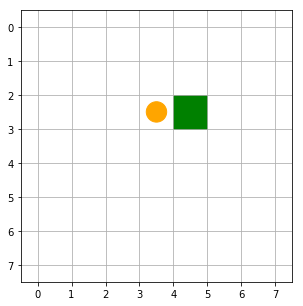

In [300]:
np.random.seed(20)
env = Environment(M, N, 1, (4, 2))
state = env.state()
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
env.render(fig, ax)

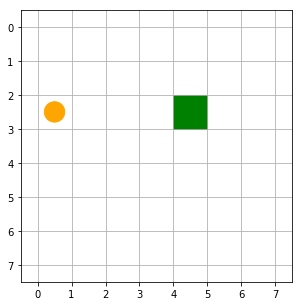

In [310]:
action = Ag.act(env.state()) # Greedy action
env.agents[0].move(action)
env.render(fig, ax)
state = env.state()
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
env.render(fig, ax)

In [934]:
def simulate(i):
    env.random_evolution()
    ax.clear()
    env.render(fig, ax)
    return (ax,)

anim = animation.FuncAnimation(fig, simulate, init_func=env.render(fig, ax),
                               frames=10, interval=200, 
                               blit=False)


HTML(anim.to_jshtml())